In [231]:
import mdtraj as md
import glob
import seaborn as sns
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np
import natsort
import itertools
%matplotlib notebook

In [232]:
sns.set(font_scale=0.8, palette=sns.color_palette(), style='white', color_codes=False) 

Read in the VR trajectories

In [233]:
vr_trajs = [] 
native_top = md.load_pdb("cypa.pdb")
filenames = natsort.natsorted(glob.glob("*_100s_*.dcd"))
for dcd in filenames:
    traj = md.load_dcd(dcd, top = "cypa_traj.pdb")
    vr_trajs.append(traj)

Let's look at the RMSD of each trajectory to see roughly what happened

<IPython.core.display.Javascript object>


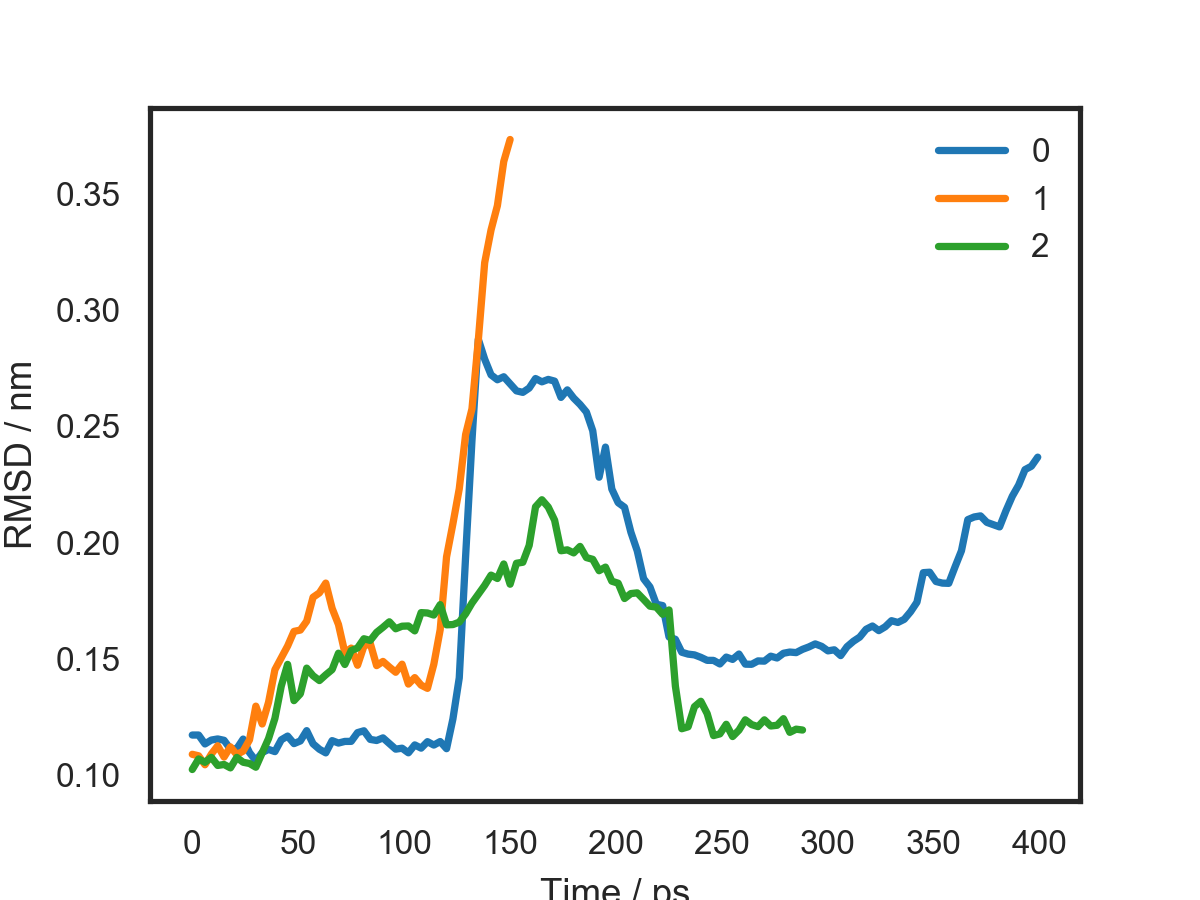

In [234]:
rmsds = [] 
times = []
# frame step was 3 picoseconds. 
framestep = 3
for traj in vr_trajs: 
    rmsds.append(md.rmsd(traj, native_top))
    # extract the frame times, it was not included in the dcd. 
    times.append([3 * x for x in range(len(traj))])
    
fig = plt.figure(dpi=300, figsize=(4,3))
i=0
# plot each rmsd
for time, rmsd, file in zip(times, rmsds, filenames):
    plt.plot(time, rmsd, label=i)
    i+=1
plt.legend()
plt.xlabel("Time / ps")
plt.ylabel("RMSD / nm")
plt.show()
plt.savefig("cypa_vr_rmsd.png")

These trajectories are of users trying to move the loop defined by residues 100-110 towards residues 67-75. The blue and green trajectories indicate the user moving the loop back and forth, while something strange happened in the orange trajectory. Residues 100-110 start near residues 80-90, so we can look at the distances between these key residues 

<IPython.core.display.Javascript object>


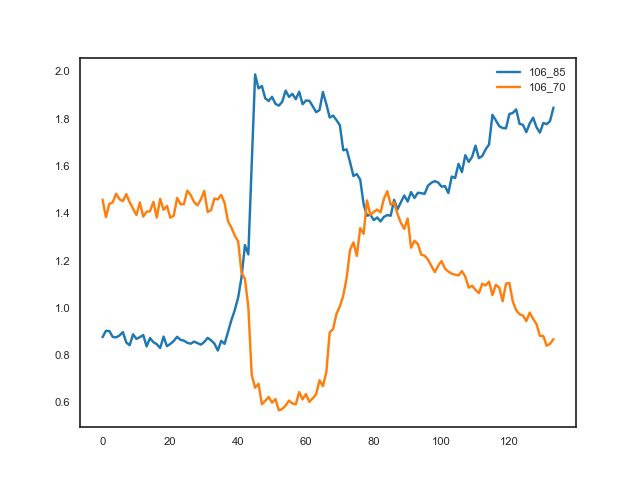

<IPython.core.display.Javascript object>


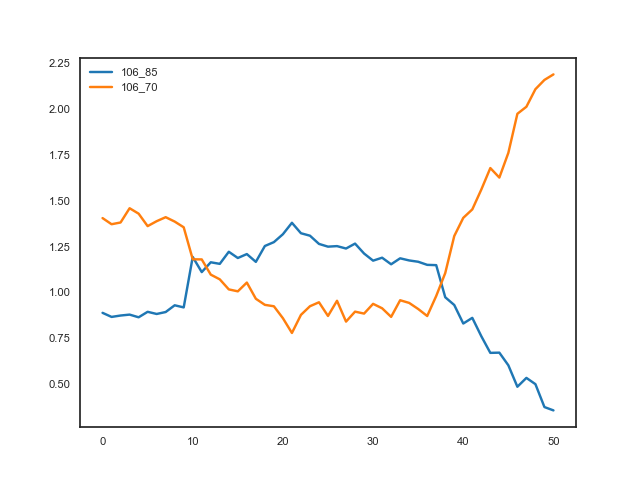

<IPython.core.display.Javascript object>


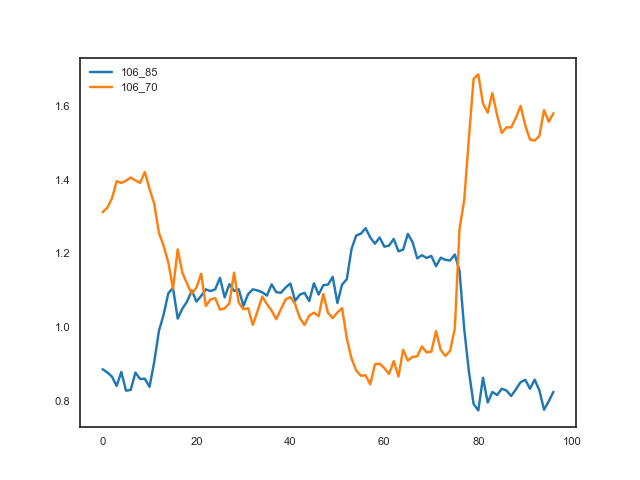

In [235]:

#100s
contacts_res = [[106, 85],[106,70]]
#70s 
#contacts_res = list(itertools.product([72], [59]))
for traj in vr_trajs:
    distances, pairs = md.compute_contacts(traj, contacts=contacts_res)
    distances = np.array(distances)
    
    fig = plt.figure()
    for i in range(len(pairs)):
        plt.plot(distances[:,i], label=str.format("{0}_{1}",pairs[i][0], pairs[i][1]))
    plt.legend()
    

In the second trajectory, the loop is brought close to residue 70, but then goes massively back the other way (the user essentially broke the protein). In the first trajectory, the loop is brought close to residue 70, away again and back.   In the last trajectory, the loop is not brought so close, but it seems to have been deposited back very near to the original state

In [236]:
nv.show_mdtraj(vr_trajs[1])

To quantify how close to the native state the secondary trajectory gets, we can compute the fraction of native contacts over the course of the trajectory:

In [237]:
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
   
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

<IPython.core.display.Javascript object>


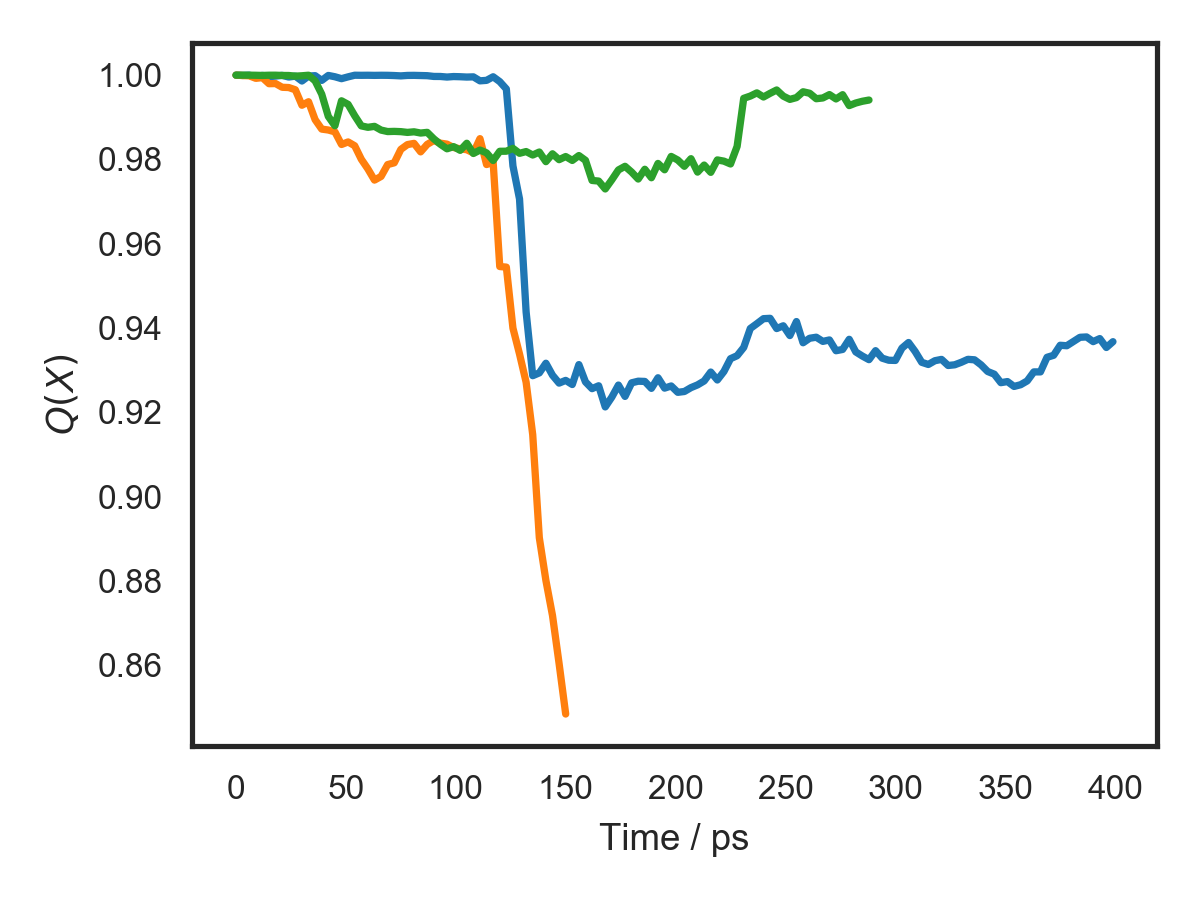

C:\Users\Mike.DESKTOP-CA70LTI\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp


Max after excursion 0.9423243
Max after excursion 0.84847623
Max after excursion 0.9964799


In [238]:
fig = plt.figure( figsize=(4,3), dpi=300)
traj_q = []
for time,traj in zip(times,vr_trajs): 
    q = best_hummer_q(traj, traj[0])
    traj_q.append(q)
    print('Max after excursion',max(q[50:]))
    plt.plot(time, q)
    plt.xlabel('Time / ps')
    plt.ylabel(r'$Q(X)$')  

plt.tight_layout()
plt.savefig("cypa_vr_native_contacts.png")

plt.show()

From these we can see that the third trajectory (in green) does indeed return to something close to the native state. The orange trajectory goes off to some crazy state, so we'll use this metric as a way to remove useless frames. This is of course context dependent - the energy of the state could be used to guide.

In [239]:
native_cutoff = 0.925
filtered_traj = []
for traj, q in zip(vr_trajs, traj_q): 
    orig_frames = traj.n_frames
    new_traj = traj[q > native_cutoff]
    print('Removed ', orig_frames - new_traj.n_frames, ' frames')
    filtered_traj.append(new_traj)
vr_trajs = filtered_traj

Removed  5  frames
Removed  6  frames
Removed  0  frames


## PCA Analysis

Let's see if we can use PCA to identify what's going on in these trajectories. We know roughly what sets of distances are important, so we'll use those contacts as the features (this could be scraped from the logging what the user does in VR). 

In [260]:
from sklearn.decomposition import PCA
# combine the trajectories.
traj = md.join(vr_trajs)
print(traj.n_frames)

271


In [261]:
#Residue pairs important in 100s loop movement
contacts_res = list(itertools.product([67+x for x in range(8)], [100+x for x in range(10)]))
contacts_res += list(itertools.product([82+x for x in range(5)], [100+x for x in range(10)]))
contacts_res += list(itertools.product([82+x for x in range(5)], [67+x for x in range(10)]))


In [262]:
pca2 = PCA(n_components=2)
# compute the pairwise distances (contacts), and run pca. 
pairwise_distances, pairs = md.compute_contacts(traj, contacts_res, scheme='closest')
print(pairwise_distances.shape, pairs.shape)
pca2.fit(pairwise_distances)
print('Explained variance', pca2.explained_variance_ratio_)

reduced_distances = pca2.fit_transform(pairwise_distances)

(271, 180) (180, 2)
Explained variance [0.66034979 0.18537333]


In [244]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# generate time dependent color maps. 
seaborn_palettes = ['Blues', 'Oranges','Greens']
cmaps = [ListedColormap(sns.color_palette(palette).as_hex()) for palette in seaborn_palettes]

In [245]:
def plot_scatters_projected_traj(trajs, projection, cmaps, xlabel, ylabel, outputfile):
    """
    Helper method to plot a projected scatter time series for the 3 separate trajectories. 
    """
    figure, axes = plt.subplots(1,4, figsize=(6,2),dpi=300, sharey=True)
    min_index = 0 
    max_index = 1
    legend_elements=[]
    # plot an overall projection of all the data
    axes[0].scatter(projection[:,0], projection[:,1], c='C4', s=9, label='All')
    # manually add legend elements
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label='All',
                              markerfacecolor='C4', markersize=4))
    xlim = axes[0].get_xlim()
    ylim = axes[0].get_ylim()
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    for ax, i, vr_traj, cmap in zip(axes[1:],range(len(trajs)), trajs,cmaps):
        max_index += vr_traj.n_frames -1
        x = projection[min_index:max_index,0]
        y = projection[min_index:max_index,1]
        ax.scatter(x, y, c=np.arange(len(x)), cmap=cmap, label=str(i), s=9)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel(xlabel)
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=str(i),
                              markerfacecolor=cmap(0.5), markersize=4))
        min_index += vr_traj.n_frames
    plt.legend(handles=legend_elements, frameon=True)
    plt.tight_layout()
    plt.show()
    plt.savefig(outputfile)

<IPython.core.display.Javascript object>


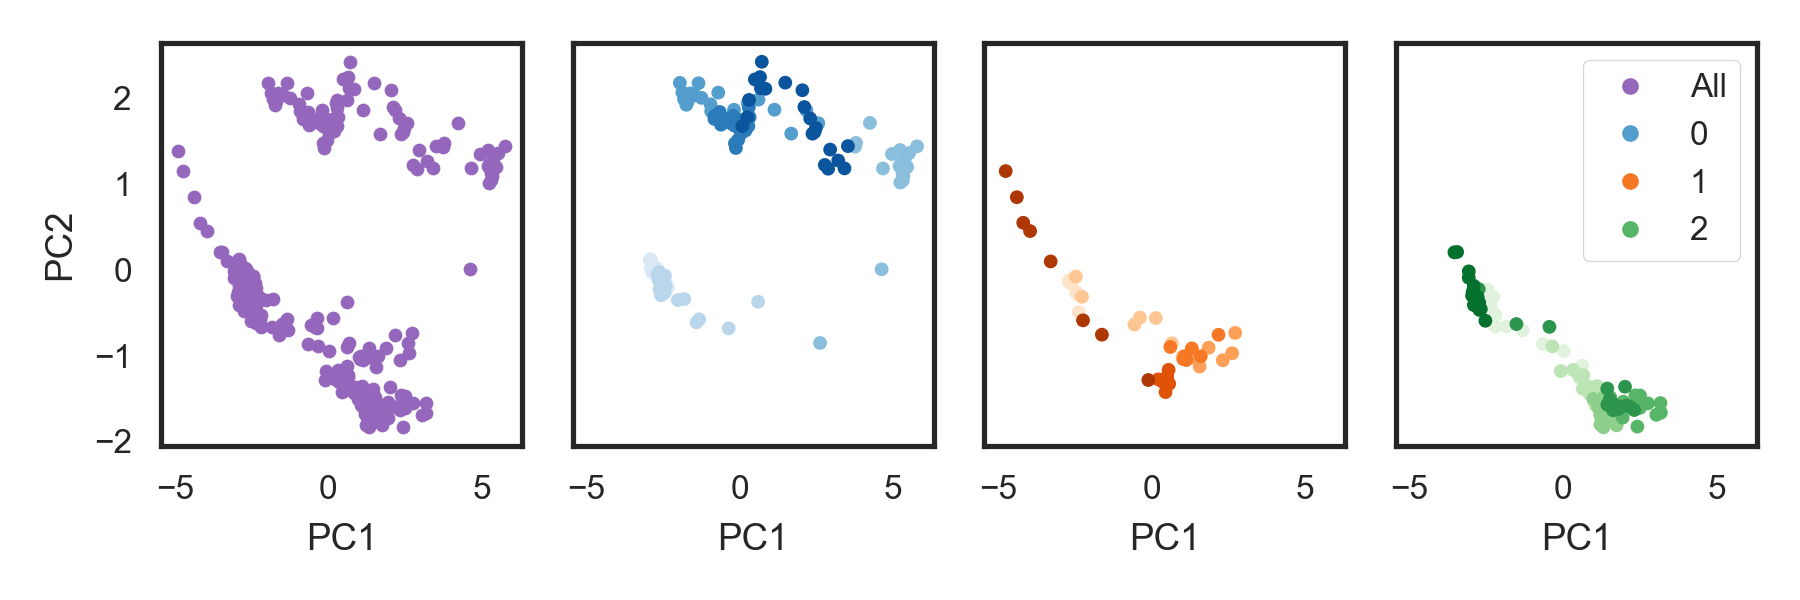

In [246]:

# build a custom legend as the dark legend colours are indistinguishable
plot_scatters_projected_traj(vr_trajs, reduced_distances, cmaps, "PC1", "PC2", "cypa_pca.png")




The two trajectories are quite clearly distinct, with the blue one covering a wider variance, while the green trajectory goes back and forth in a smaller space

## PCF Analysis For Feature Selection

We would like to know which distances are important based on the PCA. Based on this [stack overflow](https://stats.stackexchange.com/questions/108743/methods-in-r-or-python-to-perform-feature-selection-in-unsupervised-learning) answer, which is based on this [paper](http://venom.cs.utsa.edu/dmz/techrep/2007/CS-TR-2007-011.pdf) we select features. We run PCA, then cluster the resulting matrix which represents the projection of each feature. Features that are far apart in PCA space indicate that they provide useful variance. The feature closest to the center of each cluster is chosen as a feature to use. 

In [247]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X, graph_name='pfa_clusters.png'):
        if not self.q:
            self.q = X.shape[1]

        # scale the values 
        sc = StandardScaler()
        X = sc.fit_transform(X)

        # run PCA
        pca = PCA(n_components=self.q).fit(X)
        print('variance explained', pca.explained_variance_ratio_)
        A_q = pca.components_.T
        # cluster the row vectors of the A_q matrix, which represent the projection of each feature.
        kmeans = KMeans(n_clusters=self.n_features, n_init=10).fit(A_q)
        clusters = kmeans.predict(A_q)
        # compute the mean of each cluster.
        cluster_centers = kmeans.cluster_centers_
        # compute the distance between each projected vector and the center of the cluster
        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))
            
        if self.q == 2:
            fig = plt.figure(dpi=300, figsize=(3,3))
            #for cluster in A_q: 
            #    plt.scatter(row[0], row[1])
            colorbases=['tab:red', 'tab:purple', 'tab:brown']
            colors = [colorbases[i] for i in clusters]
            plt.scatter(A_q[:,0], A_q[:,1], c=colors, marker='o', s=2)
            for c in cluster_centers: 
                plt.scatter(c[0], c[1], marker='s', c=(0.4,0.4,0.4), s=25, alpha=1)
            plt.xlabel('PCA Matrix Column 0')
            plt.ylabel('PCA Matrix Column 1')
            plt.tight_layout()
            plt.savefig(graph_name)
        # the features are the features corresponding to the rows of A_q that are closest to each cluster.
        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

We'll use two PCA components, but extract 3 features to maintain variability

variance explained [0.35797442 0.28010054]


<IPython.core.display.Javascript object>


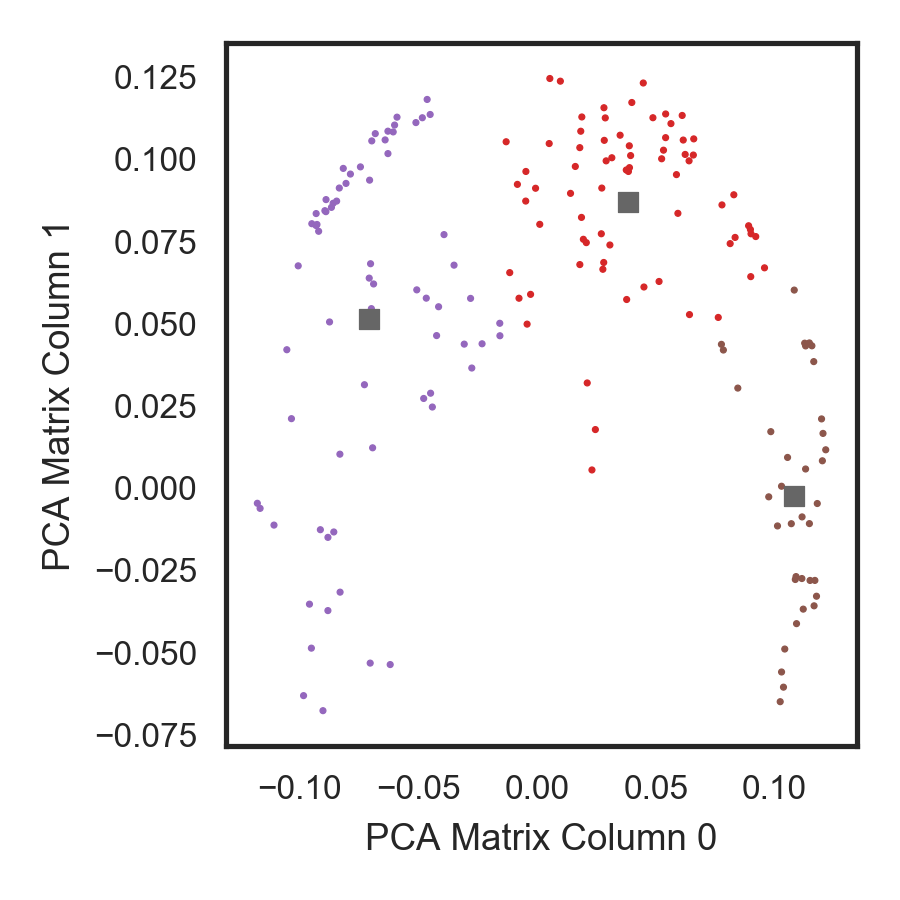

Relevant residue pairs:
[[ 82  73]
 [ 69 101]
 [ 82 102]]


In [263]:
n_features = 3
n_pca_components = 2
pfa = PFA(n_features, n_pca_components)
pfa.fit(pairwise_distances, 'pfa_clusters_vr_distances.png')

#get the feature labels 
reduced_pairs = pairs[pfa.indices_]
print("Relevant residue pairs:")
print(reduced_pairs)
#get the feature values
reduced_features = pairwise_distances[:,pfa.indices_]


The first plot shows the weights of the features in the projection space, the clustering assignments, and the centers of the clusters shown in black. The features closest to the centers are selected as the most important, the reasoning being they capture the main gist of the feature. With this method, we retrieve the following distances: distance between residues 82 and 102, which represents the loop moving away from its original position, 69 - 101, which represents the loop heading towards the 70s residue, and 82 - 73, which seems to show a small amount of relaxation in the overall loop motion, this may be an artifact of VR users relaxing the structure. A 3d plot shows the shape of the space.

<IPython.core.display.Javascript object>


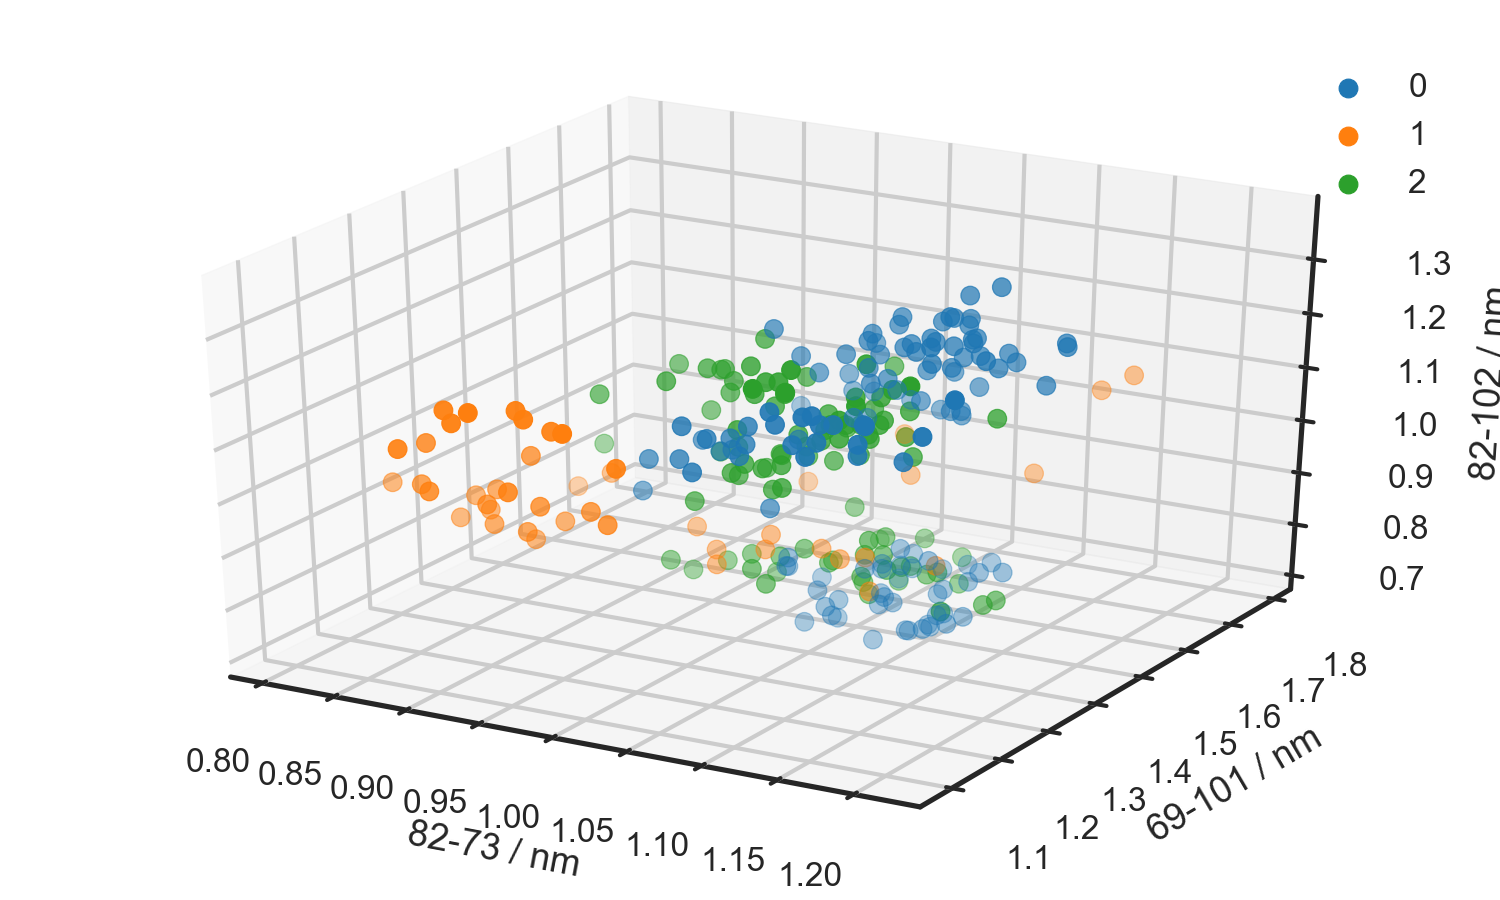

In [264]:
if n_features == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5,3), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    min_index = 0
    max_index = 0
    i=0
    for traj in vr_trajs:
        max_index += traj.n_frames
        ax.scatter(reduced_features[min_index:max_index,0], reduced_features[min_index:max_index,1],reduced_features[min_index:max_index,2], label=i)
        min_index += traj.n_frames
        i+=1
    ax.set_xlabel(str.format("{0}-{1} / nm",reduced_pairs[0][0], reduced_pairs[0][1]))
    ax.set_ylabel(str.format("{0}-{1} / nm",reduced_pairs[1][0], reduced_pairs[1][1]))
    ax.set_zlabel(str.format("{0}-{1} / nm",reduced_pairs[2][0], reduced_pairs[2][1]))
    ax.legend()
    plt.tight_layout()
    plt.savefig("cypa_features_3d.png")

In [265]:
import itertools
combinations = list(itertools.combinations(range(n_features), 2))[::-1]
print(combinations)

[(1, 2), (0, 2), (0, 1)]


1 3


<IPython.core.display.Javascript object>


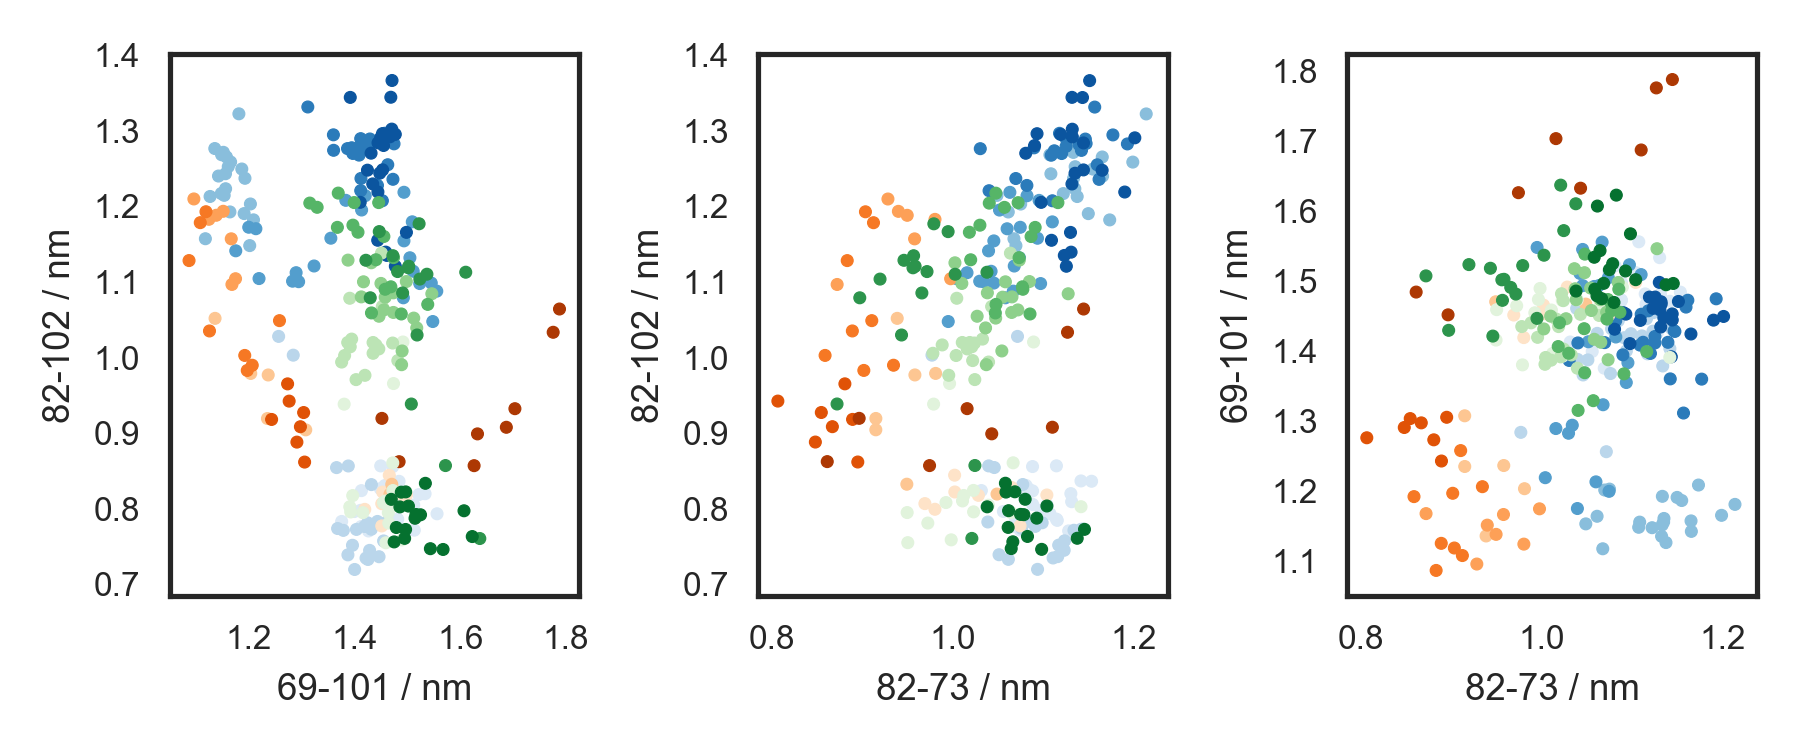

In [269]:
rows = 1
cols = int(len(combinations) / rows)
print(rows, cols)
figure, axes = plt.subplots(rows,cols, figsize=(6,2.5),dpi=300)

In [270]:
for index, combo in enumerate(combinations): 
    row = int(index / cols)
    col = int(index % cols)
    if rows > 1:
        ax = axes[row][col]
    else:
        ax = axes[index]
    min_index = 0
    max_index = 0
    
    for i, traj, cmap in zip(range(len(vr_trajs)),vr_trajs, cmaps):
        max_index += traj.n_frames
        x = reduced_features[min_index:max_index,combo[0]]
        y = reduced_features[min_index:max_index,combo[1]]
        ax.scatter(x, y, c=np.arange(len(x)), cmap=cmap, label=i, s=8)
        ax.set_xlabel(str.format("{0}-{1} / nm",reduced_pairs[combo[0]][0], reduced_pairs[combo[0]][1]))
        ax.set_ylabel(str.format("{0}-{1} / nm",reduced_pairs[combo[1]][0], reduced_pairs[combo[1]][1]))
        min_index += traj.n_frames
    plt.tight_layout()
plt.tight_layout()
plt.savefig("pfa_projections.png")

In [248]:
traj = md.join(vr_trajs)
print(traj.n_frames)

271


### Same thing, but with distances between all residues

In [249]:
pca2 = PCA(n_components=2)

pairwise_distances_all, pairs = md.compute_contacts(traj,'all', scheme='closest')

(271, 180) (13203, 2)


In [251]:
reduced_distances = pca2.fit_transform(pairwise_distances_all)

In [252]:
print('variance explained', pca2.explained_variance_ratio_)

variance explained [0.40425886 0.22679638]


<IPython.core.display.Javascript object>


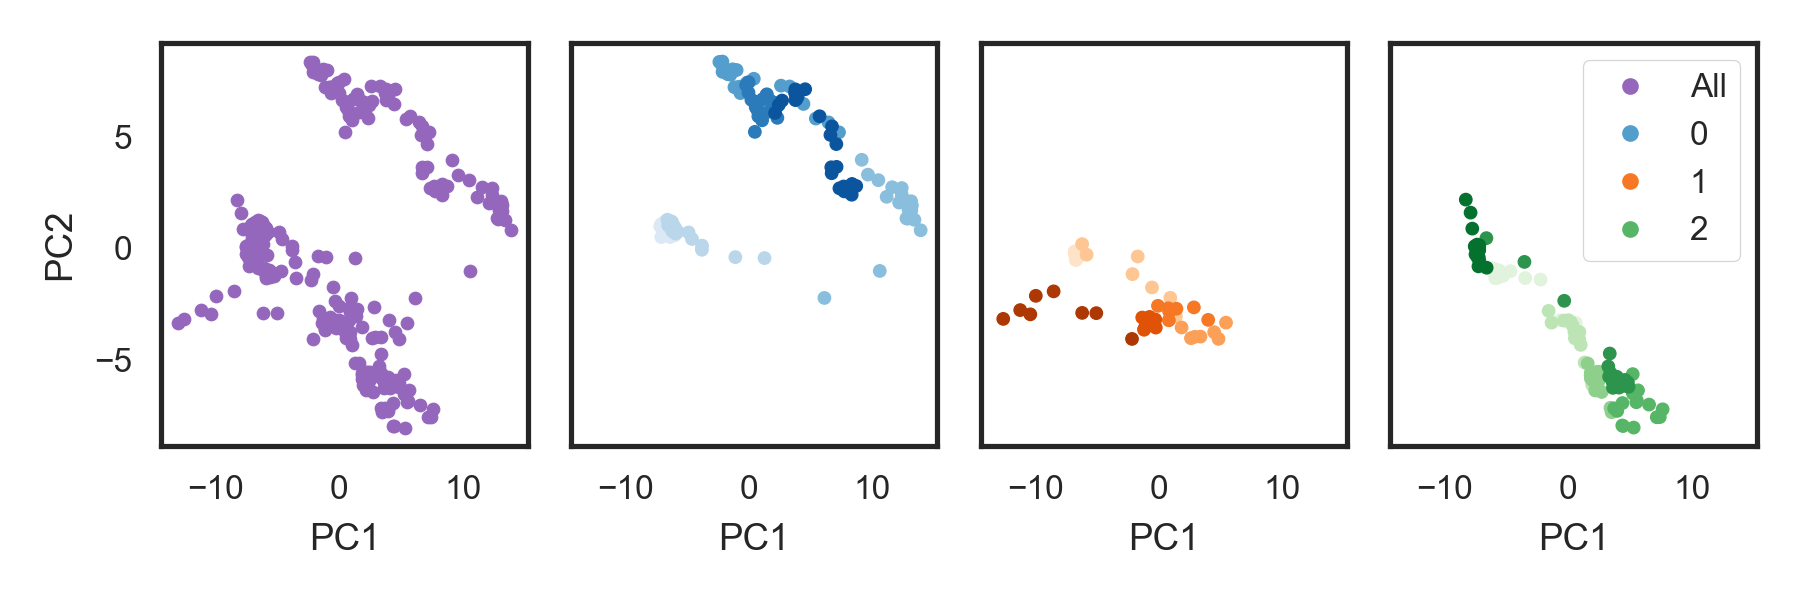

In [253]:
plot_scatters_projected_traj(vr_trajs, reduced_distances, cmaps, "PC1", "PC2", "cypa_pca_all_distances.png")

With all features, the PCA looks similar, but the feature selection does not seem to work at all

variance explained [0.16114076 0.11218132]


<IPython.core.display.Javascript object>


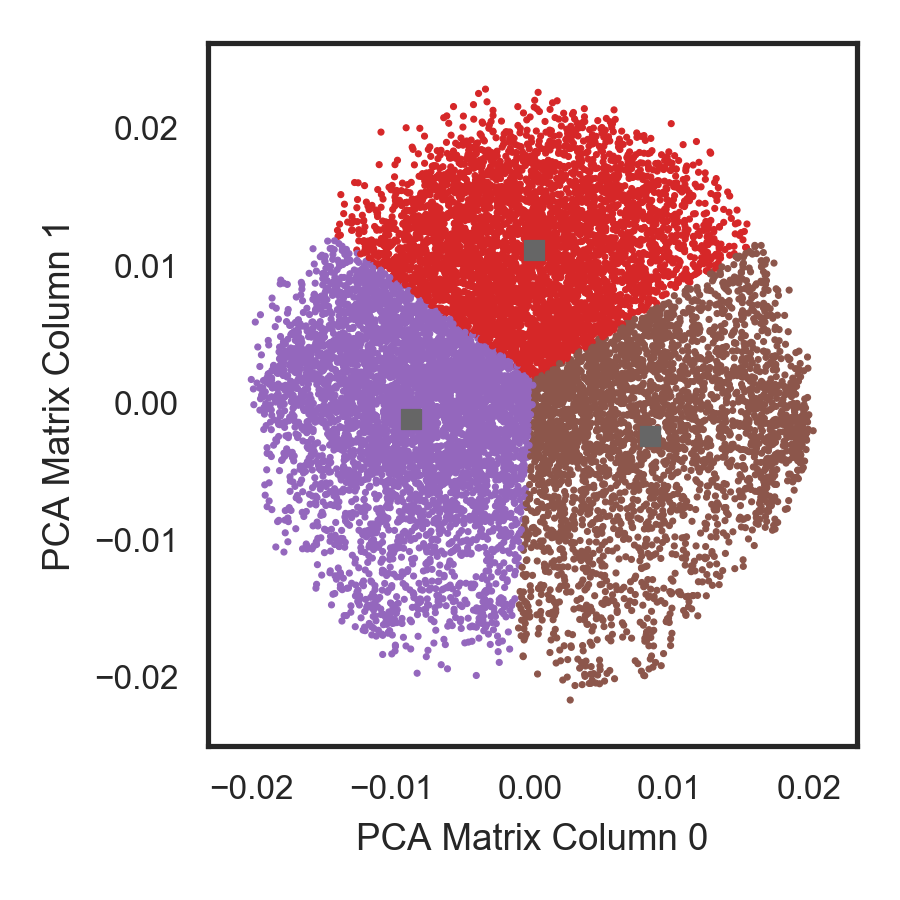

In [254]:
pfa = PFA(3, n_pca_components)
pfa.fit(pairwise_distances_all, "pfa_clusters_all_distances.png")

1 3


<IPython.core.display.Javascript object>


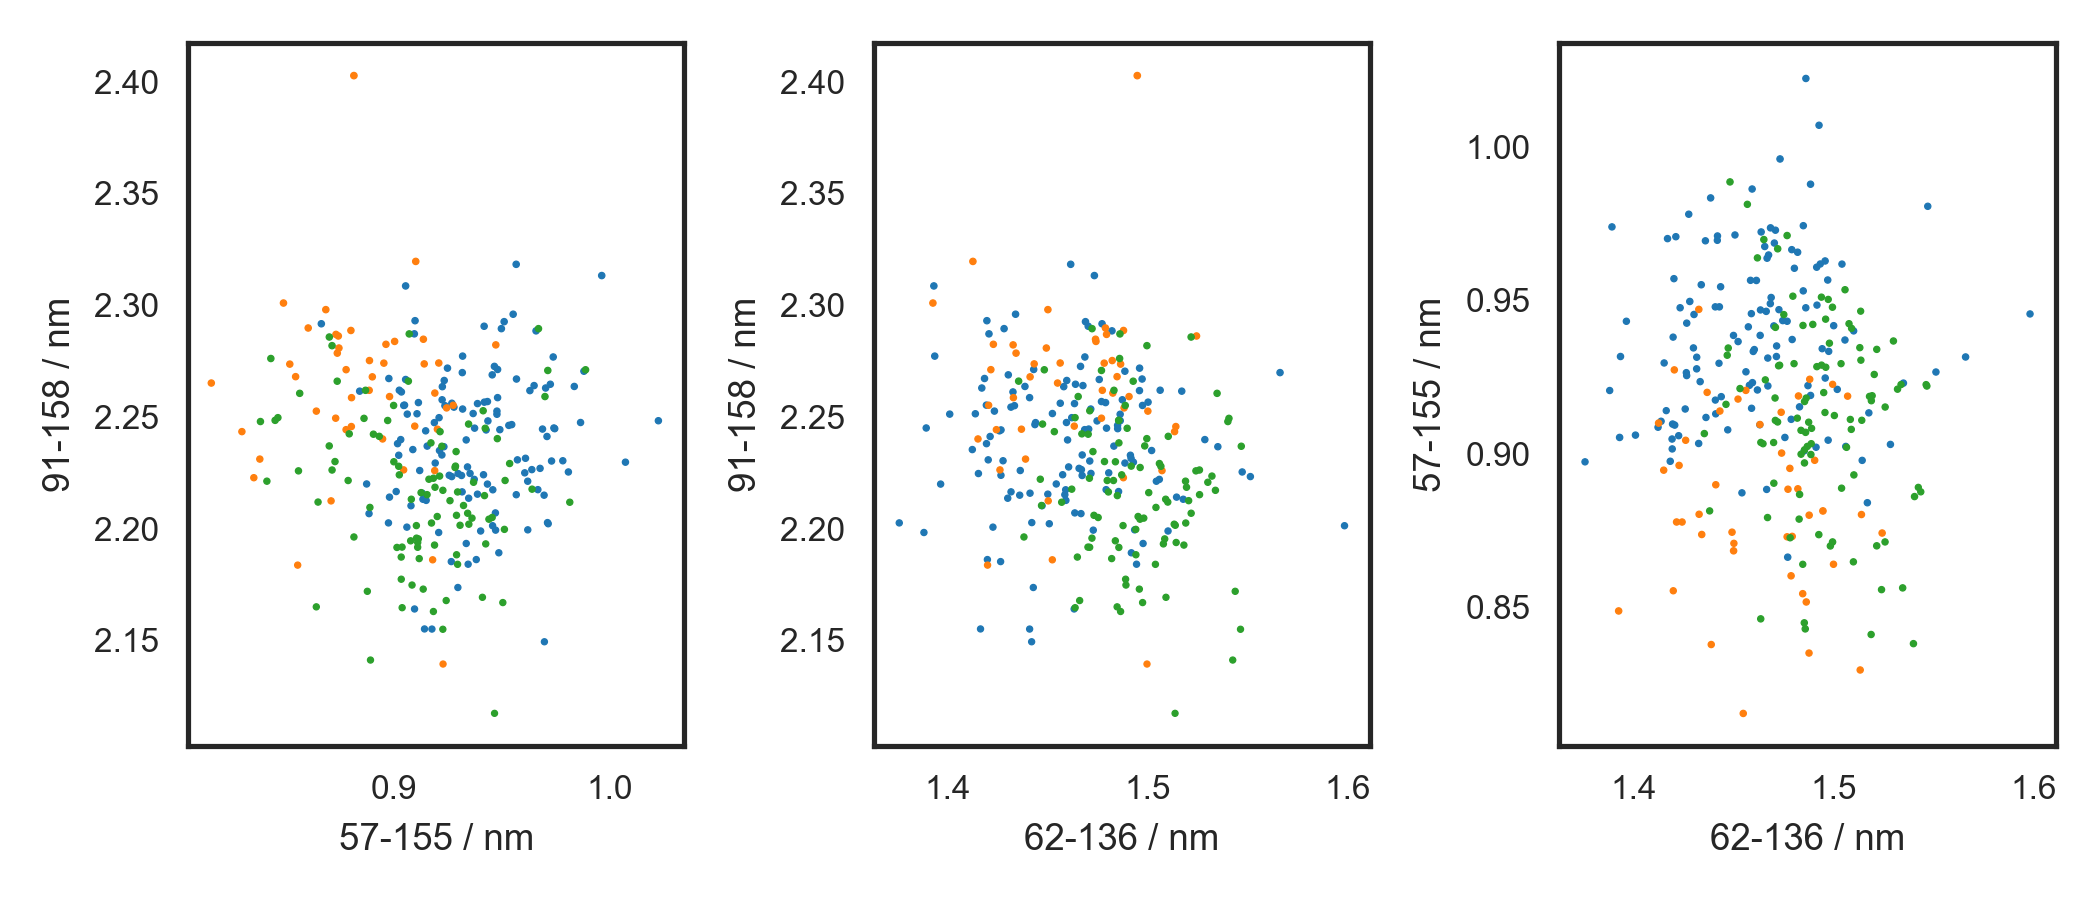

In [257]:
reduced_pairs = pairs[pfa.indices_]
reduced_features = pairwise_distances_all[:,pfa.indices_]

rows = 1
cols = int(len(combinations) / rows)
print(rows, cols)
figure, axes = plt.subplots(rows,cols, figsize=(7,3),dpi=300)
for index, combo in enumerate(combinations): 
    row = int(index / cols)
    col = int(index % cols)
    if rows > 1:
        ax = axes[row][col]
    else:
        ax = axes[index]
    min_index = 0
    max_index = 0
    for i, traj in enumerate(vr_trajs):
        max_index += traj.n_frames
        ax.scatter(reduced_features[min_index:max_index,combo[0]], reduced_features[min_index:max_index,combo[1]],reduced_features[min_index:max_index,2], label=i)
        ax.set_xlabel(str.format("{0}-{1} / nm",reduced_pairs[combo[0]][0], reduced_pairs[combo[0]][1]))
        ax.set_ylabel(str.format("{0}-{1} / nm",reduced_pairs[combo[1]][0], reduced_pairs[combo[1]][1]))
        min_index += traj.n_frames
    plt.tight_layout()
plt.tight_layout()
plt.savefig("pfa_projections_all.png")

<IPython.core.display.Javascript object>


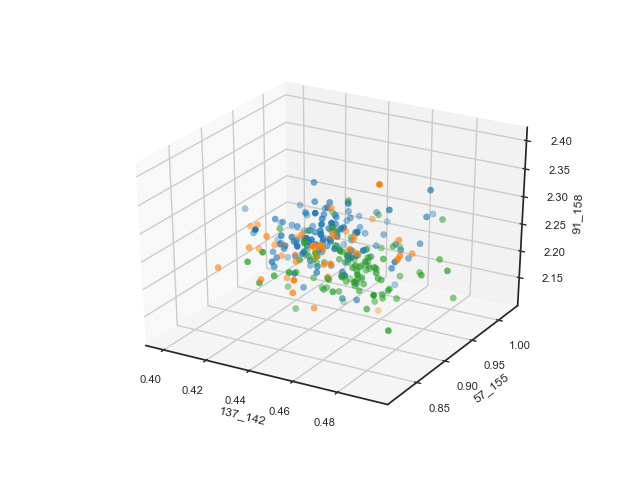

In [163]:
if n_features == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    min_index = 0
    max_index = 0
    for traj in vr_trajs:
        max_index += traj.n_frames
        ax.scatter(reduced_features[min_index:max_index,0], reduced_features[min_index:max_index,1],reduced_features[min_index:max_index,2])
        min_index += traj.n_frames
    ax.set_xlabel(str.format("{0}_{1}",reduced_pairs[0][0], reduced_pairs[0][1]))
    ax.set_ylabel(str.format("{0}_{1}",reduced_pairs[1][0], reduced_pairs[1][1]))
    ax.set_zlabel(str.format("{0}_{1}",reduced_pairs[2][0], reduced_pairs[2][1]))

With all contacts, the PFA seems to perform badly, with features quite indistinguishable from one another. 